# Method 1 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

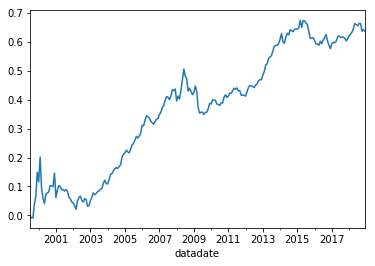

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.149312
2000-12-31   -0.002665
2001-12-31   -0.086935
2002-12-31   -0.012025
2003-12-31    0.073956
2004-12-31    0.090836
2005-12-31    0.060121
2006-12-31    0.039938
2007-12-31    0.075842
2008-12-31   -0.013680
2009-12-31   -0.020890
2010-12-31    0.014548
2011-12-31    0.005086
2012-12-31    0.037996
2013-12-31    0.085278
2014-12-31    0.031603
2015-12-31   -0.018351
2016-12-31   -0.023373
2017-12-31    0.021778
2018-12-31    0.016335
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     15.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-11
Time:                        17:59:39   Log-Likelihood:                 677.78
No. Observations:                 234   AIC:                            -1346.
Df Residuals:                     229   BIC:                            -1328.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.162      0.247      -0.001       0.003
mktrf          0.0188      0.025      0.747      0.456      -0.031       0.068
me             0.2144      0.029      7.316      0.000       0.157       0.272
ia            -0.1397      0.045     -3.138      0.002      -0.227      -0.052
roe            0.1434      0.038      3.761      0.000       0.068       0.218
==============================================================================
Omnibus:                       73.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.540
Skew:                          -0.766   Prob(JB):                    2.74e-224
Kurtosis:                      13.161   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5.207
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000495
Time:                        17:59:39   Log-Likelihood:                 677.78
No. Observations:                 234   AIC:                            -1346.
Df Residuals:                     229   BIC:                            -1328.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.087      0.277      -0.001       0.003
mktrf          0.0188      0.038      0.498      0.618      -0.055       0.093
me             0.2144      0.071      3.040      0.002       0.076       0.353
ia            -0.1397      0.116     -1.205      0.228      -0.367       0.087
roe            0.1434      0.069      2.068      0.039       0.007       0.279
==============================================================================
Omnibus:                       73.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.540
Skew:                          -0.766   Prob(JB):                    2.74e-224
Kurtosis:                      13.161   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     4.075
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00328
Time:                        17:59:39   Log-Likelihood:                 677.78
No. Observations:                 234   AIC:                            -1346.
Df Residuals:                     229   BIC:                            -1328.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.960      0.337      -0.001       0.003
mktrf          0.0188      0.028      0.663      0.508      -0.037       0.075
me             0.2144      0.076      2.838      0.005       0.066       0.362
ia            -0.1397      0.101     -1.379      0.168      -0.338       0.059
roe            0.1434      0.061      2.352      0.019       0.024       0.263
==============================================================================
Omnibus:                       73.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.540
Skew:                          -0.766   Prob(JB):                    2.74e-224
Kurtosis:                      13.161   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     11.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-09
Time:                        17:59:40   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.892      0.060    -7.4e-05       0.004
mktrf         -0.0089      0.026     -0.347      0.729      -0.059       0.042
smb            0.1569      0.034      4.640      0.000       0.090       0.224
hml           -0.1570      0.040     -3.938      0.000      -0.236      -0.078
rmw           -0.0074      0.045     -0.163      0.870      -0.096       0.081
cma            0.1102      0.057      1.923      0.056      -0.003       0.223
==============================================================================
Omnibus:                       74.946   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              965.525
Skew:                          -0.825   Prob(JB):                    2.18e-210
Kurtosis:                      12.813   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     3.067
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0106
Time:                        17:59:40   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.997      0.046    3.35e-05       0.004
mktrf         -0.0089      0.027     -0.334      0.738      -0.061       0.043
smb            0.1569      0.057      2.753      0.006       0.045       0.269
hml           -0.1570      0.049     -3.175      0.001      -0.254      -0.060
rmw           -0.0074      0.060     -0.122      0.903      -0.126       0.111
cma            0.1102      0.135      0.815      0.415      -0.155       0.375
==============================================================================
Omnibus:                       74.946   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              965.525
Skew:                          -0.825   Prob(JB):                    2.18e-210
Kurtosis:                      12.813   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     3.399
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00555
Time:                        17:59:40   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.770      0.077      -0.000       0.004
mktrf         -0.0089      0.021     -0.414      0.679      -0.051       0.033
smb            0.1569      0.049      3.183      0.001       0.060       0.254
hml           -0.1570      0.054     -2.900      0.004      -0.263      -0.051
rmw           -0.0074      0.052     -0.142      0.887      -0.109       0.094
cma            0.1102      0.143      0.769      0.442      -0.171       0.391
==============================================================================
Omnibus:                       74.946   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              965.525
Skew:                          -0.825   Prob(JB):                    2.18e-210
Kurtosis:                      12.813   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     61.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-35
Time:                        17:59:40   Log-Likelihood:                 734.84
No. Observations:                 234   AIC:                            -1460.
Df Residuals:                     229   BIC:                            -1442.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.186      0.237      -0.001       0.002
mktrf          0.0761      0.018      4.186      0.000       0.040       0.112
smb            0.0941      0.023      4.150      0.000       0.049       0.139
hml           -0.0377      0.023     -1.675      0.095      -0.082       0.007
umd            0.1875      0.015     12.682      0.000       0.158       0.217
==============================================================================
Omnibus:                       71.091   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.041
Skew:                          -0.986   Prob(JB):                    2.12e-105
Kurtosis:                       9.749   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     15.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-11
Time:                        17:59:40   Log-Likelihood:                 734.84
No. Observations:                 234   AIC:                            -1460.
Df Residuals:                     229   BIC:                            -1442.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.112      0.266      -0.001       0.002
mktrf          0.0761      0.028      2.709      0.007       0.021       0.131
smb            0.0941      0.042      2.264      0.024       0.013       0.176
hml           -0.0377      0.044     -0.868      0.386      -0.123       0.048
umd            0.1875      0.031      5.957      0.000       0.126       0.249
==============================================================================
Omnibus:                       71.091   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.041
Skew:                          -0.986   Prob(JB):                    2.12e-105
Kurtosis:                       9.749   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     14.98
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.85e-11
Time:                        17:59:40   Log-Likelihood:                 734.84
No. Observations:                 234   AIC:                            -1460.
Df Residuals:                     229   BIC:                            -1442.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.976      0.329      -0.001       0.003
mktrf          0.0761      0.023      3.295      0.001       0.031       0.121
smb            0.0941      0.031      3.027      0.002       0.033       0.155
hml           -0.0377      0.038     -0.998      0.318      -0.112       0.036
umd            0.1875      0.034      5.503      0.000       0.121       0.254
==============================================================================
Omnibus:                       71.091   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.041
Skew:                          -0.986   Prob(JB):                    2.12e-105
Kurtosis:                       9.749   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     11.47
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.15e-08
Time:                        17:59:40   Log-Likelihood:                 319.92
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.140      0.889      -0.003       0.003
mktrf          0.0653      0.044      1.474      0.143      -0.022       0.153
me             0.2745      0.044      6.275      0.000       0.188       0.361
ia            -0.1499      0.069     -2.187      0.031      -0.286      -0.014
roe            0.2379      0.061      3.923      0.000       0.118       0.358
==============================================================================
Omnibus:                       29.596   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.758
Skew:                          -0.563   Prob(JB):                     5.05e-38
Kurtosis:                       8.752   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     6.793
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.06e-05
Time:                        17:59:40   Log-Likelihood:                 319.92
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.131      0.896      -0.003       0.004
mktrf          0.0653      0.065      1.002      0.316      -0.062       0.193
me             0.2745      0.084      3.257      0.001       0.109       0.440
ia            -0.1499      0.145     -1.036      0.300      -0.433       0.134
roe            0.2379      0.085      2.792      0.005       0.071       0.405
==============================================================================
Omnibus:                       29.596   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.758
Skew:                          -0.563   Prob(JB):                     5.05e-38
Kurtosis:                       8.752   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5.853
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000253
Time:                        17:59:40   Log-Likelihood:                 319.92
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.116      0.908      -0.004       0.004
mktrf          0.0653      0.047      1.379      0.168      -0.028       0.158
me             0.2745      0.091      3.004      0.003       0.095       0.454
ia            -0.1499      0.132     -1.135      0.256      -0.409       0.109
roe            0.2379      0.065      3.678      0.000       0.111       0.365
==============================================================================
Omnibus:                       29.596   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.758
Skew:                          -0.563   Prob(JB):                     5.05e-38
Kurtosis:                       8.752   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     6.121
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-05
Time:                        17:59:40   Log-Likelihood:                 314.04
No. Observations:                 120   AIC:                            -616.1
Df Residuals:                     114   BIC:                            -599.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.842      0.402      -0.002       0.005
mktrf         -0.0029      0.049     -0.058      0.954      -0.100       0.095
smb            0.1947      0.056      3.489      0.001       0.084       0.305
hml           -0.1810      0.068     -2.647      0.009      -0.316      -0.046
rmw            0.0299      0.081      0.371      0.712      -0.130       0.190
cma            0.1488      0.088      1.685      0.095      -0.026       0.324
==============================================================================
Omnibus:                       30.540   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.533
Skew:                          -0.664   Prob(JB):                     7.55e-34
Kurtosis:                       8.361   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     2.749
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0220
Time:                        17:59:40   Log-Likelihood:                 314.04
No. Observations:                 120   AIC:                            -616.1
Df Residuals:                     114   BIC:                            -599.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.912      0.362      -0.002       0.005
mktrf         -0.0029      0.054     -0.053      0.958      -0.109       0.103
smb            0.1947      0.080      2.421      0.015       0.037       0.352
hml           -0.1810      0.073     -2.488      0.013      -0.324      -0.038
rmw            0.0299      0.088      0.339      0.735      -0.143       0.203
cma            0.1488      0.166      0.895      0.371      -0.177       0.475
==============================================================================
Omnibus:                       30.540   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.533
Skew:                          -0.664   Prob(JB):                     7.55e-34
Kurtosis:                       8.361   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     3.266
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00858
Time:                        17:59:40   Log-Likelihood:                 314.04
No. Observations:                 120   AIC:                            -616.1
Df Residuals:                     114   BIC:                            -599.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.803      0.422      -0.002       0.005
mktrf         -0.0029      0.048     -0.060      0.952      -0.097       0.091
smb            0.1947      0.068      2.878      0.004       0.062       0.327
hml           -0.1810      0.079     -2.277      0.023      -0.337      -0.025
rmw            0.0299      0.080      0.376      0.707      -0.126       0.186
cma            0.1488      0.172      0.864      0.387      -0.189       0.486
==============================================================================
Omnibus:                       30.540   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.533
Skew:                          -0.664   Prob(JB):                     7.55e-34
Kurtosis:                       8.361   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     43.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.15e-22
Time:                        17:59:40   Log-Likelihood:                 354.87
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.070      0.287      -0.001       0.004
mktrf          0.1171      0.029      4.016      0.000       0.059       0.175
smb            0.0836      0.033      2.517      0.013       0.018       0.149
hml           -0.0314      0.033     -0.944      0.347      -0.097       0.034
umd            0.2232      0.021     10.885      0.000       0.183       0.264
==============================================================================
Omnibus:                       43.528   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.596
Skew:                          -1.215   Prob(JB):                     4.93e-36
Kurtosis:                       8.159   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     23.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.42e-14
Time:                        17:59:40   Log-Likelihood:                 354.87
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.994      0.320      -0.001       0.004
mktrf          0.1171      0.042      2.794      0.005       0.035       0.199
smb            0.0836      0.049      1.691      0.091      -0.013       0.180
hml           -0.0314      0.050     -0.629      0.530      -0.129       0.067
umd            0.2232      0.032      6.892      0.000       0.160       0.287
==============================================================================
Omnibus:                       43.528   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.596
Skew:                          -1.215   Prob(JB):                     4.93e-36
Kurtosis:                       8.159   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     29.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.59e-17
Time:                        17:59:40   Log-Likelihood:                 354.87
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.901      0.367      -0.002       0.004
mktrf          0.1171      0.027      4.314      0.000       0.064       0.170
smb            0.0836      0.034      2.445      0.015       0.017       0.151
hml           -0.0314      0.045     -0.698      0.485      -0.120       0.057
umd            0.2232      0.029      7.706      0.000       0.166       0.280
==============================================================================
Omnibus:                       43.528   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.596
Skew:                          -1.215   Prob(JB):                     4.93e-36
Kurtosis:                       8.159   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.266
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000141
Time:                        17:59:40   Log-Likelihood:                 414.63
No. Observations:                 114   AIC:                            -819.3
Df Residuals:                     109   BIC:                            -805.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.666      0.009       0.000       0.003
mktrf          0.0107      0.019      0.558      0.578      -0.027       0.049
me             0.0515      0.030      1.743      0.084      -0.007       0.110
ia            -0.1520      0.041     -3.705      0.000      -0.233      -0.071
roe           -0.0639      0.036     -1.774      0.079      -0.135       0.008
==============================================================================
Omnibus:                        1.348   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.059
Skew:                          -0.233   Prob(JB):                        0.589
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.181
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000161
Time:                        17:59:40   Log-Likelihood:                 414.63
No. Observations:                 114   AIC:                            -819.3
Df Residuals:                     109   BIC:                            -805.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.527      0.012       0.000       0.003
mktrf          0.0107      0.017      0.611      0.541      -0.024       0.045
me             0.0515      0.043      1.185      0.236      -0.034       0.137
ia            -0.1520      0.051     -3.007      0.003      -0.251      -0.053
roe           -0.0639      0.047     -1.348      0.178      -0.157       0.029
==============================================================================
Omnibus:                        1.348   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.059
Skew:                          -0.233   Prob(JB):                        0.589
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.726
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.09e-05
Time:                        17:59:40   Log-Likelihood:                 414.63
No. Observations:                 114   AIC:                            -819.3
Df Residuals:                     109   BIC:                            -805.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.071      0.038    9.24e-05       0.003
mktrf          0.0107      0.016      0.671      0.502      -0.021       0.042
me             0.0515      0.043      1.202      0.229      -0.033       0.136
ia            -0.1520      0.048     -3.161      0.002      -0.246      -0.058
roe           -0.0639      0.044     -1.455      0.146      -0.150       0.022
==============================================================================
Omnibus:                        1.348   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.059
Skew:                          -0.233   Prob(JB):                        0.589
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     8.297
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-06
Time:                        17:59:40   Log-Likelihood:                 421.36
No. Observations:                 114   AIC:                            -830.7
Df Residuals:                     108   BIC:                            -814.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.510      0.014       0.000       0.003
mktrf          0.0199      0.017      1.151      0.252      -0.014       0.054
smb            0.0557      0.028      1.983      0.050    3.68e-05       0.111
hml           -0.1153      0.036     -3.219      0.002      -0.186      -0.044
rmw           -0.1173      0.044     -2.675      0.009      -0.204      -0.030
cma           -0.0408      0.056     -0.733      0.465      -0.151       0.070
==============================================================================
Omnibus:                        2.471   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.916
Skew:                          -0.282   Prob(JB):                        0.384
Kurtosis:                       3.291   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     7.388
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.42e-06
Time:                        17:59:40   Log-Likelihood:                 421.36
No. Observations:                 114   AIC:                            -830.7
Df Residuals:                     108   BIC:                            -814.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.481      0.013       0.000       0.003
mktrf          0.0199      0.020      1.000      0.317      -0.019       0.059
smb            0.0557      0.031      1.821      0.069      -0.004       0.116
hml           -0.1153      0.035     -3.263      0.001      -0.185      -0.046
rmw           -0.1173      0.036     -3.267      0.001      -0.188      -0.047
cma           -0.0408      0.060     -0.679      0.497      -0.159       0.077
==============================================================================
Omnibus:                        2.471   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.916
Skew:                          -0.282   Prob(JB):                        0.384
Kurtosis:                       3.291   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     6.601
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.13e-05
Time:                        17:59:40   Log-Likelihood:                 421.36
No. Observations:                 114   AIC:                            -830.7
Df Residuals:                     108   BIC:                            -814.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.127      0.033       0.000       0.003
mktrf          0.0199      0.020      1.000      0.317      -0.019       0.059
smb            0.0557      0.029      1.922      0.055      -0.001       0.113
hml           -0.1153      0.035     -3.340      0.001      -0.183      -0.048
rmw           -0.1173      0.040     -2.959      0.003      -0.195      -0.040
cma           -0.0408      0.055     -0.740      0.460      -0.149       0.067
==============================================================================
Omnibus:                        2.471   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.916
Skew:                          -0.282   Prob(JB):                        0.384
Kurtosis:                       3.291   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     9.676
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.82e-07
Time:                        17:59:40   Log-Likelihood:                 420.15
No. Observations:                 114   AIC:                            -830.3
Df Residuals:                     109   BIC:                            -816.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.690      0.094      -0.000       0.002
mktrf          0.0369      0.017      2.132      0.035       0.003       0.071
smb            0.0775      0.027      2.876      0.005       0.024       0.131
hml           -0.0882      0.028     -3.178      0.002      -0.143      -0.033
umd            0.0502      0.021      2.395      0.018       0.009       0.092
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.577
Skew:                          -0.273   Prob(JB):                        0.455
Kurtosis:                       2.814   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     14.70
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-09
Time:                        17:59:40   Log-Likelihood:                 420.15
No. Observations:                 114   AIC:                            -830.3
Df Residuals:                     109   BIC:                            -816.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.647      0.099      -0.000       0.002
mktrf          0.0369      0.016      2.373      0.018       0.006       0.067
smb            0.0775      0.032      2.458      0.014       0.016       0.139
hml           -0.0882      0.032     -2.720      0.007      -0.152      -0.025
umd            0.0502      0.017      2.922      0.003       0.017       0.084
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.577
Skew:                          -0.273   Prob(JB):                        0.455
Kurtosis:                       2.814   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     13.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.14e-09
Time:                        17:59:40   Log-Likelihood:                 420.15
No. Observations:                 114   AIC:                            -830.3
Df Residuals:                     109   BIC:                            -816.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.469      0.142      -0.000       0.002
mktrf          0.0369      0.014      2.702      0.007       0.010       0.064
smb            0.0775      0.033      2.373      0.018       0.013       0.142
hml           -0.0882      0.032     -2.756      0.006      -0.151      -0.025
umd            0.0502      0.018      2.813      0.005       0.015       0.085
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.577
Skew:                          -0.273   Prob(JB):                        0.455
Kurtosis:                       2.814   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""